In [12]:
import numpy as np
import matplotlib.pyplot as plt

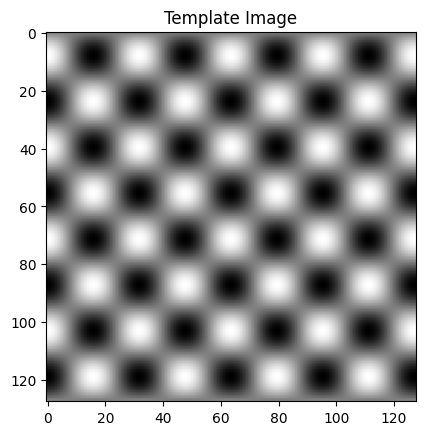

In [13]:
# Create an example template NxM image say I(X, Y) = sin(8 \pi X) cos(8 \pi Y)  

# Create a grid of points  
N = 128 
M = 128
x = np.linspace(0, 1, N) 
y = np.linspace(0, 1, M) 
X, Y = np.meshgrid(x, y, indexing='ij')

# Create the template image
I = np.sin(8 * np.pi * X) * np.cos(8 * np.pi * Y) 

# Display the template image  
plt.imshow(I, cmap='gray') 
plt.title('Template Image') 
plt.show() 

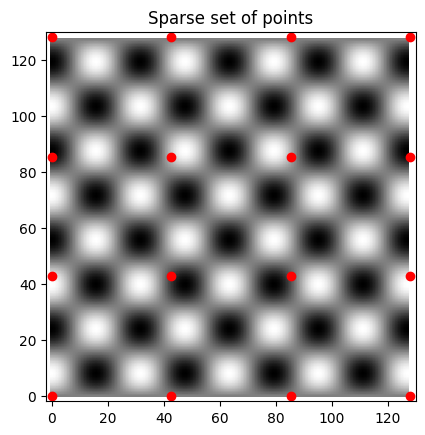

In [14]:
# Create a sparse set of points 3x3 evenly distributed over the image domain  

# Create a grid of points 
C_n = 4 # number of points in x direction
C_m = 4 # number of points in y direction
c_x_n = np.linspace(0, 1, C_n) 
c_y_m = np.linspace(0, 1, C_m) 
C_x_n, C_y_m = np.meshgrid(c_x_n, c_y_m, indexing='ij')

# Create the sparse set of points 
C = np.vstack((C_x_n.flatten(), C_y_m.flatten())).T

# Display the sparse set of points 
plt.imshow(I, cmap='gray') 
plt.scatter(C[:, 0] * N, C[:, 1] * M, c='r') 
plt.title('Sparse set of points')  
plt.xlim([-2, N+2]) 
plt.ylim([-2, M+2])
plt.show()

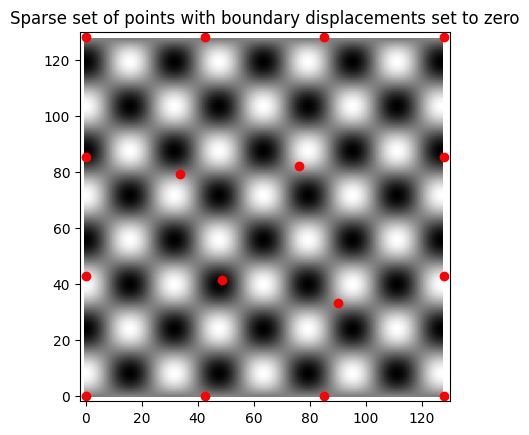

In [15]:
# Displace the sparse set of points by uniformly distributed random displacements 

# Create the random displacements   
max_d_x = 10
max_d_y = 10
dx_lims = [-max_d_x/N, max_d_x/N] 
dy_lims = [-max_d_y/M, max_d_y/M]

# Initialize displacements to zero for all points
dx = np.zeros(C.shape[0])
dy = np.zeros(C.shape[0])

# Determine which points are not on the boundary
not_on_boundary = (C[:, 0] > 0) & (C[:, 0] < 1) & (C[:, 1] > 0) & (C[:, 1] < 1)

# Apply random displacements only to points not on the boundary
dx[not_on_boundary] = np.random.uniform(dx_lims[0], dx_lims[1], np.sum(not_on_boundary))
dy[not_on_boundary] = np.random.uniform(dy_lims[0], dy_lims[1], np.sum(not_on_boundary))

# Combine the displacements and apply them to the original points
dC = C + np.vstack((dx, dy)).T

# Ensure the displaced points are still within the bounds [0, 1]
dC = np.clip(dC, 0, 1)

# Display the sparse set of points with displacements applied
plt.imshow(I, cmap='gray')
plt.scatter(dC[:, 0] * N, dC[:, 1] * M, c='r')
plt.title('Sparse set of points with boundary displacements set to zero')
plt.xlim([-2, N+2])
plt.ylim([-2, M+2])
plt.show()

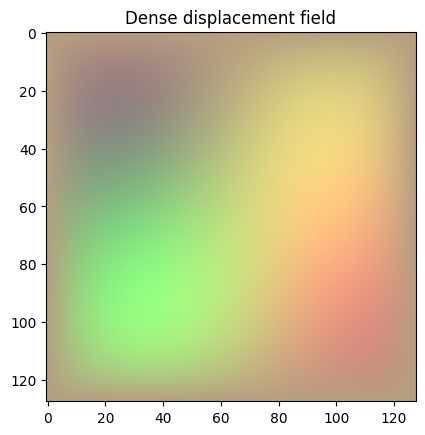

In [16]:
# Interpolate the displacement field C' = C - dC using a Cubic B-Spline     

from scipy.interpolate import RectBivariateSpline  

dC_inv = C - dC 

# Create the interpolator 
C_x = np.linspace(0, 1, C_n)
C_y = np.linspace(0, 1, C_m)  

dC_x_spline = RectBivariateSpline(C_x, C_y, dC_inv[:, 0].reshape(C_m, C_n))    
dC_y_spline = RectBivariateSpline(C_x, C_y, dC_inv[:, 1].reshape(C_m, C_n))

# Create the dense displacement field   
dC_x_dense = dC_x_spline(x, y) 
dC_y_dense = dC_y_spline(x, y) 

# Convert the dense displacement field to RGB for display  
dC_x_dense_rgb = (dC_x_dense - np.min(dC_x_dense)) / (np.max(dC_x_dense) - np.min(dC_x_dense)) 
dC_y_dense_rgb = (dC_y_dense - np.min(dC_y_dense)) / (np.max(dC_y_dense) - np.min(dC_y_dense)) 
dC_dense_rgb = np.stack((dC_x_dense_rgb, dC_y_dense_rgb, np.zeros_like(dC_x_dense_rgb)), axis=-1)  

# Display the dense displacement field 
plt.imshow(dC_dense_rgb, alpha=0.5) 
plt.title('Dense displacement field')  
plt.show()

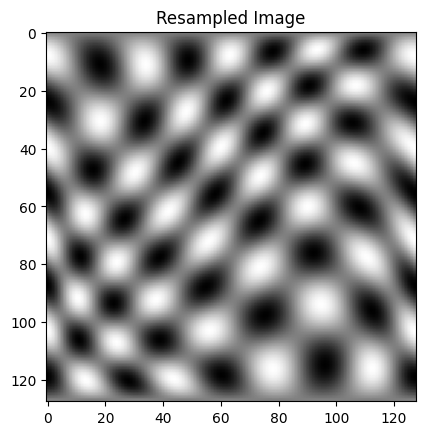

In [17]:
# Resample the template image using the dense displacement field. 
# Use linear interpolation as the resampling method.

from scipy.interpolate import RegularGridInterpolator as rgi    

# Create the interpolator 
interpolator = rgi((x, y), I, method='linear', bounds_error=False, fill_value=0)

# Create the resampled image 
X_dense = X + dC_x_dense 
Y_dense = Y + dC_y_dense  

# Clip the dense coordinates to ensure they are within the bounds of the original grid
X_dense_clipped = np.clip(X_dense, np.min(x), np.max(x))
Y_dense_clipped = np.clip(Y_dense, np.min(y), np.max(y))

# Use the clipped coordinates for interpolation
J = interpolator((X_dense_clipped, Y_dense_clipped))

# Display the resampled image 
plt.imshow(J, cmap='gray') 
plt.title('Resampled Image') 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999235113880169..0.9999235113880169].


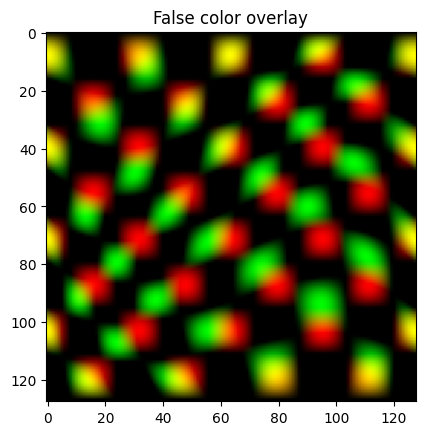

In [18]:
# Plot the original and warped image using a false color overlay 

# Create an RGB image with the original and warped image 
false_colour = np.zeros((M, N, 3)) 
false_colour[:, :, 0] = I 
false_colour[:, :, 1] = J

# Display the false color overlay 
plt.imshow(false_colour) 
plt.title('False color overlay') 
plt.show()
